In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import TFAutoModel, AutoTokenizer, BertForSequenceClassification, pipeline, BertTokenizerFast
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
import torch

In [2]:
df = pd.read_csv("cleaned.csv")
df.head()

,text,label,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,Pillowcases & Shams,0,Not Dark Pattern
2,Write a review,0,Not Dark Pattern
3,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,newsletter signup (privacy policy),0,Not Dark Pattern


In [3]:
fine = df['category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [4]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [5]:
id2fine

{0: 'Urgency',
 1: 'Not Dark Pattern',
 2: 'Scarcity',
 3: 'Misdirection',
 4: 'Social Proof',
 5: 'Obstruction',
 6: 'Sneaking',
 7: 'Forced Action'}

In [6]:
fine2id

{'Urgency': 0,
 'Not Dark Pattern': 1,
 'Scarcity': 2,
 'Misdirection': 3,
 'Social Proof': 4,
 'Obstruction': 5,
 'Sneaking': 6,
 'Forced Action': 7}

In [7]:
df.drop('label', axis=1, inplace=True)

In [8]:
df.head()

,text,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,Pillowcases & Shams,Not Dark Pattern
2,Write a review,Not Dark Pattern
3,"To start your return, simply click on the foll...",Not Dark Pattern
4,newsletter signup (privacy policy),Not Dark Pattern


In [9]:
df['labels']=df.category.map(lambda x: fine2id[x.strip()])

In [10]:
df

,text,category,labels
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,Pillowcases & Shams,Not Dark Pattern,1
2,Write a review,Not Dark Pattern,1
3,"To start your return, simply click on the foll...",Not Dark Pattern,1
4,newsletter signup (privacy policy),Not Dark Pattern,1
...,...,...,...
3863,TWO FREE PILLOWS AND 30% OFF WITH PROMO CODE,Misdirection,3
3864,Compare at,Misdirection,3
3865,$132.90 $99.00,Misdirection,3
3866,This offer is only VALID if you add to cart now!,Misdirection,3


<Axes: ylabel='count'>

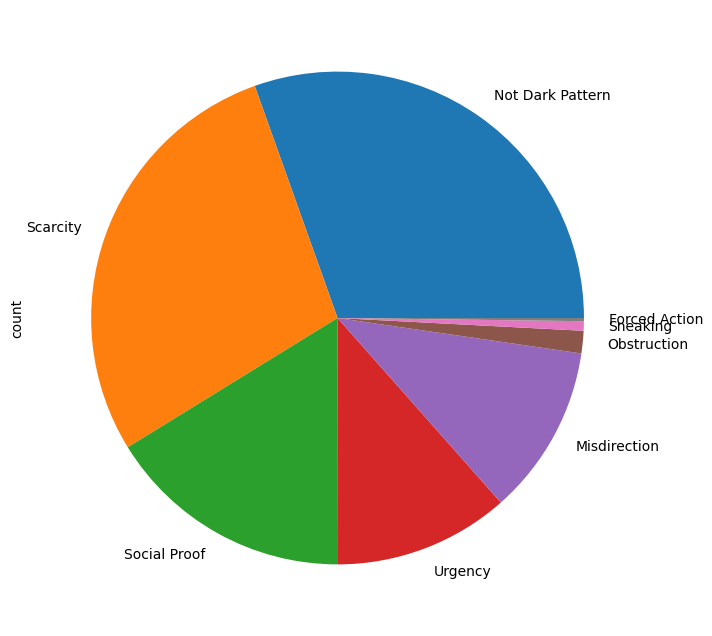

In [11]:
df.category.value_counts().plot(kind='pie', figsize=(8,8))

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", max_length=512)

In [13]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_fine,
                                                      id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [14]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2:(3*SIZE)//4])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])

In [15]:
len(train_texts), len(val_texts), len(test_texts)

(1934, 967, 967)

In [16]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
if len(val_texts) > 0:
    val_encodings = tokenizer(val_texts, truncation=True, padding=True)
else:
    val_encodings = None  # or handle it accordingly)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [17]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [18]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

In [19]:
from transformers import TrainingArguments, Trainer

In [20]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [21]:
training_args = TrainingArguments(
    output_dir="./TTC4908Model",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)

In [22]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)

In [23]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,1.750100,1.515525,0.322647,0.199014,0.258338,0.250888
100,0.671000,0.321022,0.946225,0.588909,0.591143,0.588671
150,0.221400,0.134055,0.967942,0.605545,0.601629,0.609642
200,0.167200,0.136329,0.962771,0.630977,0.717836,0.625078
250,0.147400,0.112457,0.973113,0.714092,0.713253,0.715008
300,0.091800,0.111640,0.973113,0.707484,0.700318,0.715640
350,0.067300,0.110245,0.978283,0.717424,0.716404,0.718513


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metr

TrainOutput(global_step=363, training_loss=0.4305840151040679, metrics={'train_runtime': 10022.2772, 'train_samples_per_second': 0.579, 'train_steps_per_second': 0.036, 'total_flos': 602312151473856.0, 'train_loss': 0.4305840151040679, 'epoch': 3.0})

In [24]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs['logits'].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label

    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label

In [25]:
model_path = "DPBH_BERT_Fine_Tuned_Model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('DPBH_BERT_Fine_Tuned_Model\\tokenizer_config.json',
 'DPBH_BERT_Fine_Tuned_Model\\special_tokens_map.json',
 'DPBH_BERT_Fine_Tuned_Model\\vocab.txt',
 'DPBH_BERT_Fine_Tuned_Model\\added_tokens.json',
 'DPBH_BERT_Fine_Tuned_Model\\tokenizer.json')

In [26]:
# Reload the model

model_path = "DPBH_BERT_Fine_Tuned_Model"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [27]:
nlp("Haris just bought an airplane at just rs 99")

[{'label': 'Social Proof', 'score': 0.9949702620506287}]

In [28]:
nlp("Hurry, exclusive offer – only 3 units remaining, don't miss out on this limited-time opportunity!")

[{'label': 'Scarcity', 'score': 0.979070782661438}]

In [29]:
nlp("10 minutes left")

[{'label': 'Scarcity', 'score': 0.6656845808029175}]

In [30]:
nlp("Don't miss out on our premium subscription - upgrade now and avoid being stuck with the basic features that only a few people settle for.")

[{'label': 'Misdirection', 'score': 0.9645480513572693}]

In [31]:
nlp("Unlock the full experience by clicking 'Upgrade Now' and leave behind the limitations of the standard version – your journey to superior benefits begins here!")

[{'label': 'Misdirection', 'score': 0.660565972328186}]

In [32]:
nlp("Upgrade to our premium membership now or risk missing out on the exclusive benefits that only a few savvy individuals are securing – limited spots available!")

[{'label': 'Misdirection', 'score': 0.883713960647583}]

In [33]:
nlp("Don't subscribe now and unsubscribe later, because you wont get less knowledge")

[{'label': 'Misdirection', 'score': 0.7075169086456299}]

In [34]:
nlp("Rohan has 5 airplane and now he owns 6. How? Because he is not an idiot like you.")

[{'label': 'Not Dark Pattern', 'score': 0.6206623315811157}]

In [35]:
nlp("")

[{'label': 'Not Dark Pattern', 'score': 0.9930243492126465}]